This notebook works with the 2020 US Census data as optimized for use on the Microsoft Planetary Computer. While this is one step removed from the original source, it is a really powerful format on a high performance cloud system we can various kinds of processing. Establishing a connection at the initiation of place political/administrative divisions will help as we build more sophisticated processing into the GeoKB.

To run these codes fully, you need to establish your own connection on the MPC Hub (a Pangeo environment). I'm working this from a desktop connection in VSCode where I first spin up an MPC machine accessible through an API token and then connect to that as an existing Jupyter server. At that point, I'm running code blocks on that machine within a connected notebook, so any data I need to operate on and connections I need to make back out have to be done from that machine. This does include spinning up additional runtime packages on the MPC Hub machine, which unfortunately, cannot be persisted across sessions at this time. It's a minor inconvenience paid for access to awesome big data!

In [1]:
import os
import geopandas as gpd
import planetary_computer
import pystac_client
import pandas as pd
from lxml import etree
import markdown

from wbmaker import WikibaseConnection

### Data Assets

MPC Hub machines come pre-configured with access to a slate of data assets on the Azure cloud that are built with STAC metadata for discovery and access. There are quite a number of [public data assets there](https://planetarycomputer.microsoft.com/catalog), including USGS Landsat, Lidar, and many others. Here, I tap the collection for US Census and take a look at what's available to get specific asset identifiers.

In [2]:
data_catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = data_catalog.search(collections=["us-census"])
items = {item.id: item for item in search.items()}
list(items)

['2020-census-blocks-population',
 '2020-census-blocks-geo',
 '2020-cb_2020_us_vtd_500k',
 '2020-cb_2020_us_unsd_500k',
 '2020-cb_2020_us_ttract_500k',
 '2020-cb_2020_us_tract_500k',
 '2020-cb_2020_us_tbg_500k',
 '2020-cb_2020_us_state_500k',
 '2020-cb_2020_us_sldu_500k',
 '2020-cb_2020_us_sldl_500k',
 '2020-cb_2020_us_scsd_500k',
 '2020-cb_2020_us_region_500k',
 '2020-cb_2020_us_place_500k',
 '2020-cb_2020_us_nectadiv_500k',
 '2020-cb_2020_us_necta_500k',
 '2020-cb_2020_us_nation_5m',
 '2020-cb_2020_us_metdiv_500k',
 '2020-cb_2020_us_elsd_500k',
 '2020-cb_2020_us_division_500k',
 '2020-cb_2020_us_csa_500k',
 '2020-cb_2020_us_cousub_500k',
 '2020-cb_2020_us_county_within_cd116_500k',
 '2020-cb_2020_us_county_500k',
 '2020-cb_2020_us_concity_500k',
 '2020-cb_2020_us_cnecta_500k',
 '2020-cb_2020_us_cd116_500k',
 '2020-cb_2020_us_cbsa_500k',
 '2020-cb_2020_us_bg_500k',
 '2020-cb_2020_us_aitsn_500k',
 '2020-cb_2020_us_aiannh_500k',
 '2020-cb_2020_72_subbarrio_500k',
 '2020-cb_2020_02_anrc_

### STAC Metadata
The first thing I'll take a look at is the dataset for American Indian lands. We can display that one to see what STAC metadata contains. This is bare minimum metadata letting us know what's there and how to access it. We'd have to dig a bit more behind the scenes when we want more, but this is enough for basic data access and exploration. We'll work below on starting with STAC metadata to document items in our GeoKB for these sources.

In [3]:
key_aiannh = "2020-cb_2020_us_aiannh_500k"
item_aiannh = items[key_aiannh]
asset_aiannh = item_aiannh.assets["data"]
item_aiannh

ID: 2020-cb_2020_us_aiannh_500k
"Bounding Box: [-174.234518442577, 18.9106023402031, -67.0385279826039, 71.3397102533974]"
Datetime: 2021-08-01 00:00:00+00:00
datetime: 2021-08-01T00:00:00Z
proj:epsg: 4269
"table:columns: [{'name': 'AIANNHCE', 'type': 'int64', 'description': 'AIANNH census code'}, {'name': 'AIANNHNS', 'type': 'int64'}, {'name': 'AFFGEOID', 'type': 'byte_array', 'description': 'American FactFinder summary level code + geovariant code + ""00US"" + GEOID'}, {'name': 'GEOID', 'type': 'byte_array', 'description': 'concatenation of AIANNH census code and reservation/statistical area or off-reservation trust land Hawaiian home land indicator'}, {'name': 'NAME', 'type': 'byte_array', 'description': 'Current Area Name'}, {'name': 'NAMELSAD', 'type': 'byte_array', 'description': 'Current name and legal/statistical status for each entity'}, {'name': 'LSAD', 'type': 'byte_array', 'description': 'Current legal/statistical area code'}, {'name': 'ALAND', 'type': 'int64', 'description': 'Current land area'}, {'name': 'AWATER', 'type': 'int64', 'description': 'Current water area'}, {'name': 'geometry', 'type': 'byte_array', 'description': 'coordinates for AIANNH polygons'}]"
table:row_count: 704
"stac_extensions: ['https://stac-extensions.github.io/table/v1.2.0/schema.json', 'https://stac-extensions.github.io/projection/v1.0.0/schema.json']"
https://stac-extensions.github.io/table/v1.2.0/schema.json
https://stac-extensions.github.io/projection/v1.0.0/schema.json
href: abfs://us-census/2020/cb_2020_us_aiannh_500k.parquet


### Reading Data to Dataframes

 We see that these assets include a parquet file, which is actually "GeoParquet" in that it includes the full polygon or multi-polygon boundary for the areas. We can read in three datasets that we can work from to build out GeoKB items to serve as references for tribal areas, states, and counties. There may be others that we want to get here eventually as well, but this serves as a start.

In [56]:
# Get tribal, state, county areas and set CRS for integration into Wikibase instance
gdf_aiannh = gpd.read_parquet(
    asset_aiannh.href,
    storage_options=asset_aiannh.extra_fields["table:storage_options"]
)
gdf_aiannh.to_crs(epsg=4326, inplace=True)
gdf_aiannh['abfs'] = asset_aiannh.href

key_states = "2020-cb_2020_us_state_500k"
item_states = items[key_states]
asset_states = item_states.assets["data"]
gdf_states = gpd.read_parquet(
    asset_states.href,
    storage_options=asset_states.extra_fields["table:storage_options"]
)
gdf_states.to_crs(epsg=4326, inplace=True)
gdf_states['abfs'] = asset_states.href

key_counties = "2020-cb_2020_us_county_500k"
item_counties = items[key_counties]
asset_counties = item_counties.assets['data']
gdf_counties = gpd.read_parquet(
    asset_counties.href,
    storage_options=asset_counties.extra_fields["table:storage_options"]
)
gdf_counties.to_crs(epsg=4326, inplace=True)
gdf_counties['abfs'] = asset_counties.href


### Looking at the data

It doesn't take all that long to load these since it's not massive, but once we get down to doing actual geospatial processing, we can load the data into DASK GeoDataFrames instead and distribute processing. Here are a couple quick views to check what we loaded.

In [5]:
gdf_states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,66,1802705,0400000US66,66,GU,Guam,00,543555847,934337453,"MULTIPOLYGON (((144.64538 13.23627, 144.64716 ..."
1,48,1779801,0400000US48,48,TX,Texas,00,676680588914,18979352230,"MULTIPOLYGON (((-94.71830 29.72885, -94.71721 ..."
2,55,1779806,0400000US55,55,WI,Wisconsin,00,140292246684,29343721650,"MULTIPOLYGON (((-86.95617 45.35549, -86.95463 ..."
3,44,1219835,0400000US44,44,RI,Rhode Island,00,2677759219,1323691129,"MULTIPOLYGON (((-71.28802 41.64558, -71.28647 ..."
4,36,1779796,0400000US36,36,NY,New York,00,122049520861,19256750161,"MULTIPOLYGON (((-72.03683 41.24984, -72.03496 ..."


<AxesSubplot:>

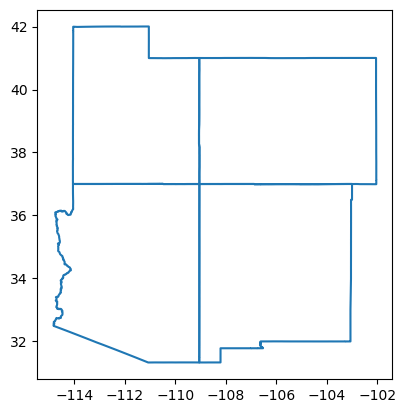

In [6]:
gdf_states[gdf_states.STUSPS.isin(['CO','UT','AZ','NM'])].boundary.plot()

### What do we need in the GeoKB

We have lots of cases where we link to these and other political/administrative divisions as well as some geoscientifically important "boundaries" we need to establish references for. We'll start with these and then use the design pattern for more interesting and challenging data sources. One thing the MPC STAC metadata does not do very well is connect all the dots for us. We have to go digging for that. We get an overview of the US Census data [here](https://planetarycomputer.microsoft.com/dataset/us-census). We have to track down links from there to understand what all the fields here mean. One of the most complete sources is this [attribute glossary](https://tigerweb.geo.census.gov/tigerwebmain/TIGERweb_attribute_glossary.html) that gives us at least some specific clues on the fields we see in this MPC derivative. Typical GIS metadata in FGDC CSDGM or ISO19115 formats are often more complete, but those can also be challenging in that there are hundreds of derivations of those same metadata spun up in all the places there are GIS service references or GIS downloads for these data. We need to get better at this so that every field name like these comes along with a persistent, resolvable identifier that gets us to the full details.

In this case, we'll work with the following for now as the most important for us to work with:
* NAME and NAMELSAD (labels) - We'll make labels out of these. I'm trying to follow a rule that labels are unique within a classification context. In the case of Native American lands, we can use the NAMELSAD as it is unique within that context. It may not, however, prove to the be the best label to use in the long run and we may want to adjust. We'll logically put some things together to make that reality here like combining the full county name and a state or territory name and making sure that label is unique with the classification for counties and equivalent. At the same time, we will include any other names that don't make up the label as aliases in the records so they are available for search.
* GEOID - This is the common identifier for the US Census TIGER data across the board, but it means something different depending on which dataset. In some cases, these are also FIPS codes from the older FIPS standard that is now basically defunct but still necessary as a connector.
* STATEFP and COUNTYFP - If you look at the data, you'll see these are what's in the GEOID field, but they are also broken out. We'll want these in our system as FIPS codes and we'll treat the GEOID separately as a link back to other Census data. We'll also use the STATEFP from counties to create a link to the U.S. State items we establish in the GeoKB.
* AIANNHNS, STATENS, and COUNTYNS - All these "NS" identifiers are for the Geographic Names Information System, so we'll bring those in to establish the link. In the GeoKB, we've set up "formatter URL" properties that establish the URL pattern for identifiers like these to an associated resolver, so these become live links to the GNIS.
* geometry - It is useful to have a basic point representation for as many geographically specific areas as possible in the GeoKB. We'll calculate centroids from full geometry for the time being. We'll try to handle multipolygon geometry more elegantly by finding the nearest individual polygon centroid to the calculated centroid on the footprint and using that as a "representational point."

Note: AIANNHCE is another specific code for American Indian / Alaska Native / Native Hawaiian areas that we'll keep in mind if we have need to link on it from some source where GEOID will not suffice.

In [59]:
def representational_point(geom):
    '''
    Function takes a MultiPolygon or Polygon geometry object and returns a reasonable representational point that
    is at least somewhere within one of the polygons of a multipolygon geometry.
    '''
    full_geom_centroid = gpd.GeoSeries.from_xy(
        x=[geom.centroid.x],
        y=[geom.centroid.y],
    )

    if geom.geom_type == "Polygon":
        return full_geom_centroid[0]
    else:
        x = []
        y = []
        for g in geom.geoms:
            x.append(g.centroid.x)
            y.append(g.centroid.y)
        multi_centroids = gpd.GeoSeries.from_xy(x, y)
        distance_measure = multi_centroids.distance(full_geom_centroid[0])
        return multi_centroids[distance_measure.argmin()]


In [60]:
# Generate usable county label
gdf_counties['label'] = gdf_counties.apply(lambda x: f"{x.NAMELSAD}, {x.STATE_NAME}", axis=1)

# Extrct best representational point for each unit
gdf_aiannh['representational_point'] = gdf_aiannh.geometry.apply(representational_point)
gdf_aiannh['lon'] = gdf_aiannh.representational_point.x
gdf_aiannh['lat'] = gdf_aiannh.representational_point.y

gdf_states['representational_point'] = gdf_states.geometry.apply(representational_point)
gdf_states['lon'] = gdf_states.representational_point.x
gdf_states['lat'] = gdf_states.representational_point.y

gdf_counties['representational_point'] = gdf_counties.geometry.apply(representational_point)
gdf_counties['lon'] = gdf_counties.representational_point.x
gdf_counties['lat'] = gdf_counties.representational_point.y

## Work with Wikibase instance

Now that we have our named areas, we can build out items in a Wikibase instance. I've started a Python class for this interaction that handles much of the logistical work of setting up a connection. One wrinkle in that here is that the MPC folks have made things a little bit challenging on managing environments. My code in this class relies on a set of environment variables containing connection information to a given Wikibase instance and connection parameters like login credentials for a bot we're using in a given operation. I don't want to stop storing these as env variables, so I worked up a somewhat cumbersome process of dropping a script file with that information onto the MPC instance and reading them from there as needed. It's not great, but I haven't worked out something better yet. It is reasonably secure, because no one else is able to access that machine.

In [62]:
geokb = WikibaseConnection('GEOKB_XENTITY', include_namespaces=False)

### Properties and Classes

We'll be mapping dataset references as items into our GeoKB source and then building out the named place references themselves. When we do that, we'll be using a set of properties in the GeoKB to provide claims about the items and a set of "subclass" items to provide classification. The WikibaseConnection class retrieves these fundamental information points for reference when it is instantiated, and we take a look at them here.

In [63]:
display(geokb.prop_lookup)
display(geokb.class_lookup)

{'instance of': 'P2',
 'subclass of': 'P3',
 'related wikidata property': 'P4',
 'related wikidata item': 'P5',
 'formatter URL': 'P6',
 'data source': 'P7',
 'data format': 'P8',
 'item of this property': 'P9',
 'equivalent property': 'P10',
 'reference URL': 'P11',
 'coordinate location': 'P12',
 'geographical location': 'P13',
 'country': 'P14',
 'U.S. state': 'P15',
 'U.S. county': 'P16',
 'municipality': 'P17',
 'ISO 3166-1 numeric code': 'P18',
 'ISO 3166-1 alpha-2 code': 'P19',
 'ISO 3166-1 alpha-3 code': 'P20',
 'ISO 3166-2 code': 'P21',
 'FIPS 6-4': 'P22',
 'FIPS 5-2 numeric': 'P23',
 'FIPS 5-2 alpha': 'P24',
 'FIPS 55-3': 'P25',
 'GNIS ID': 'P26',
 'NAICS Code': 'P27',
 'SIC code': 'P28',
 'query string': 'P29',
 'caveat': 'P30',
 'html table': 'P31',
 'table ordinal': 'P32',
 'technical documentation': 'P33',
 'FIPS 10-4': 'P34',
 'entity classifier': 'P35',
 'TIGER GEOID': 'P36',
 'property from data source': 'P37',
 'source property': 'P38',
 'latitude': 'P39',
 'longitude

{'property': 'Q2',
 'spatio-temporal entity': 'Q3',
 'location': 'Q4',
 'object': 'Q8',
 'temporal entity': 'Q5',
 'spatial entity': 'Q6',
 'country': 'Q12',
 'U.S. Territory': 'Q13',
 'U.S. State': 'Q14',
 'U.S. federal district': 'Q15',
 'U.S. Federal American Indian Reservation': 'Q18',
 'Hawaiian Home Land': 'Q19',
 'U.S. County (or equivalent)': 'Q20',
 'U.S. Congressional District': 'Q21',
 'American Indian/Alaska Native/Hawaiian Home Lands': 'Q32',
 'human activity': 'Q7',
 'legislative term': 'Q22',
 'business': 'Q16',
 'political institution': 'Q23',
 'economic sector': 'Q24',
 'artificial entity': 'Q9',
 'work': 'Q10',
 'dataset': 'Q11',
 'Alaska Native Regional Corporation': 'Q17'}

### Document Source Items

We want enough information in our knowledgebase that it can be reasonably self sufficient on functionality that is core to operations within the knowledgebase. This means we need to have a representation for the things we want to link to and query about. Many of those are going to be "appropriated" from other places, including other knowledge representations, through the actions of bots like this one. I'm exploring how best to document data sources like those we are processing here as items classed as "dataset" (or maybe others in future) that can be linked to from the references part of claims. We'll keep working through this process to see how best to represent data sources and the details on how we are using them.

Note: The following approach to putting together source items is terrible and should not be used by anyone else. You won't be able to write to the GeoKB pilot instance anyway, but I know this is ugly code with way too much hard coding. There will be a lot better way to handle this, and I need to come up with some standardized process for pulling select items in from a STAC catalog to represent as dataset items in a knowledgebase. But this brute force method will suffice for the moment.

In [41]:
def parse_desc(desc: dict, license: str):
    item_info = {
        "label": f'{desc["name"]} (U.S. Census TIGER data transformed to parquet for Microsoft Planetary Computer)',
        "license": license,
        "links": []
    }

    description = desc['description']
    reference_links = []
    doc = etree.fromstring(markdown.markdown(description))
    for link in doc.xpath('//a'):
        description = description.replace(f"[{link.text}]", link.text)
        description = description.replace(f"({link.get('href')})", "")
        reference_links.append(link.get('href'))

    if len(description) > 250:
        item_info["description"] = description.split(".")[0]
    else:
        item_info["description"] = description

    if reference_links:
        item_info["links"].append({
            "url": reference_links[0],
            "type": "text/html",
            "title": "Dataset description and documentation from source"
        })
    
    return item_info

data_source_items = []

us_census_item = item_aiannh.get_parent()
us_census_meta = us_census_item.to_dict()
us_census_tables = us_census_meta['table:tables']

license_url = next((i['href'] for i in us_census_meta['links'] if i["rel"] == 'license'), None)
human_readable_reference = next((i['href'] for i in us_census_meta['links'] if i["rel"] == 'describedby'), None)

parent_item = {
    "label": "U.S. Census data as part of open public data catalog on the Microsoft Planetary Computer",
    "description": "U.S. Census data for 2020 Census sourced from TIGER Web by Microsoft and processed by makepath.com",
    "license": license_url,
    "links": [
        {
            "url": us_census_item.get_self_href(),
            "type": "application/json",
            "title": "Dataset collection documentation from STAC catalog"
        }
    ]
}

if human_readable_reference is not None:
    parent_item["links"].append({
        "url": human_readable_reference,
        "type": "text/html",
        "title": "Human readable description of the collection of data assets on the Microsoft Planetary Computer"
    })

data_source_items.append(parent_item)

aiannh_item = parse_desc(
    next(i for i in us_census_tables if i['msft:item_name'] == key_aiannh.replace('2020-', '')),
    license_url
)
aiannh_item["abfs"] = {
    "url": asset_aiannh.to_dict()["href"],
    "type": asset_aiannh.to_dict()["type"],
    "title": "Link to the specific data asset available on Azure public data cloud"
}
aiannh_item["links"].append({
    "url": next(i["href"] for i in item_aiannh.to_dict()["links"] if i["rel"] == "self"),
    "type": "application/geo+json",
    "title": "Link to GeoJSON representation of dataset metadata"
})
data_source_items.append(aiannh_item)

states_item = parse_desc(
    next(i for i in us_census_tables if i['msft:item_name'] == key_states.replace('2020-', '')),
    license_url
)
states_item["abfs"] = {
    "url": asset_states.to_dict()["href"],
    "type": asset_states.to_dict()["type"],
    "title": "Link to the specific data asset available on Azure public data cloud"
}
states_item["links"].append({
    "url": next(i["href"] for i in item_states.to_dict()["links"] if i["rel"] == "self"),
    "type": "application/geo+json",
    "title": "Link to GeoJSON representation of dataset metadata"
})
data_source_items.append(states_item)

counties_item = parse_desc(
    next(i for i in us_census_tables if i['msft:item_name'] == key_counties.replace('2020-', '')),
    license_url
)
counties_item["abfs"] = {
    "url": asset_counties.to_dict()["href"],
    "type": asset_counties.to_dict()["type"],
    "title": "Link to the specific data asset available on Azure public data cloud"
}
counties_item["links"].append({
    "url": next(i["href"] for i in item_counties.to_dict()["links"] if i["rel"] == "self"),
    "type": "application/geo+json",
    "title": "Link to GeoJSON representation of dataset metadata"
})
data_source_items.append(counties_item)


In [42]:
data_source_items

[{'label': 'U.S. Census data as part of open public data catalog on the Microsoft Planetary Computer',
  'description': 'U.S. Census data for 2020 Census sourced from TIGER Web by Microsoft and processed by makepath.com',
  'license': 'https://www.census.gov/about/policies/open-gov/open-data.html',
  'links': [{'url': 'https://planetarycomputer.microsoft.com/api/stac/v1/collections/us-census',
    'type': 'application/json',
    'title': 'Dataset collection documentation from STAC catalog'},
   {'url': 'https://planetarycomputer.microsoft.com/dataset/us-census',
    'type': 'text/html',
    'title': 'Human readable description of the collection of data assets on the Microsoft Planetary Computer'}]},
 {'label': 'American Indian/Alaska Native Areas/Hawaiian Home Lands (AIANNH) (U.S. Census TIGER data transformed to parquet for Microsoft Planetary Computer)',
  'license': 'https://www.census.gov/about/policies/open-gov/open-data.html',
  'links': [{'url': 'https://www.census.gov/programs-

### Data Source Item Building Process

I'm still fiddling with various methods for building items into a Wikibase instance. The simple serial looping method here is kind of dumb, and I have built a couple renditions of a BuildItem Python class that would be more robust. However, I'm also still working out the best way to model everything so it's all a bit fluid. I'm also not yet sure on the best way to parallelize the process against the Wikibase API. WikibaseIntegrator, the underlying API abstraction I'm using, has a "fastrun" mode that sets a basic "envelope" of how items will be structured and then operates quickly within that. There's another approach in RaiseWikibase (another less mature Python project) I'm exploring, and Jonathan Oliveros has explored yet another approach with pywikibot. His approach relies on a logical mapping of something like the above structure to what we want things to end up as in the knowledge graph, which is a sound idea.

In the meantime, the following loop approach lays things out in a way I can work through the modeling of items logically and figure out what goes where. It also lets me visually test whether or not the item building process builds an actual conformant item structure with a simple print before writing the item.

In [43]:
ref_qualifiers = geokb.models.Qualifiers()
ref_qualifiers.add(
    geokb.datatypes.String(
        prop_nr=geokb.prop_lookup['title'],
        value="U.S. Census public data asset on Microsoft Planetary Computer"
    )
)

refs = geokb.models.References()
refs.add(
    geokb.datatypes.URL(
        prop_nr=geokb.prop_lookup['reference URL'],
        value=human_readable_reference,
        qualifiers=ref_qualifiers
    )
)

parent_item_id = None
for num, item in enumerate(data_source_items):
    new_item = geokb.wbi.item.new()
    new_item.labels.set('en', item['label'])
    new_item.descriptions.set('en', item['description'])

    # instance of classification
    new_item.claims.add(
        geokb.datatypes.Item(
            prop_nr=geokb.prop_lookup['instance of'],
            value=geokb.class_lookup['dataset'],
            references=refs
        )
    )

    # License designation
    new_item.claims.add(
        geokb.datatypes.URL(
            prop_nr=geokb.prop_lookup['license URL'],
            value=item['license'],
            references=refs
        )
    )

    # Add part of claim
    if parent_item_id is not None:
        new_item.claims.add(
            geokb.datatypes.Item(
                prop_nr=geokb.prop_lookup['part of'],
                value=parent_item_id,
                references=refs
            )
        )

    # Add link claims as reference URLs
    reference_url_claims = []
    for link in item["links"]:
        link_q = geokb.models.Qualifiers()
        link_q.add(
            geokb.datatypes.String(
                prop_nr=geokb.prop_lookup['title'],
                value=link['title']
            )
        )
        link_q.add(
            geokb.datatypes.String(
                prop_nr=geokb.prop_lookup['MIME type'],
                value=link['type']
            )
        )
        reference_url_claims.append(
            geokb.datatypes.URL(
                prop_nr=geokb.prop_lookup['reference URL'],
                value=link['url'],
                qualifiers=link_q,
                references=refs
            )
        )

    new_item.claims.add(reference_url_claims)

    # Add ABFS link
    if "abfs" in item:
        abfs_q = geokb.models.Qualifiers()
        abfs_q.add(
            geokb.datatypes.String(
                prop_nr=geokb.prop_lookup['title'],
                value=item['abfs']['title']
            )
        )
        abfs_q.add(
            geokb.datatypes.String(
                prop_nr=geokb.prop_lookup['MIME type'],
                value=item['abfs']['type']
            )
        )
        new_item.claims.add(
            geokb.datatypes.String(
                prop_nr=geokb.prop_lookup['Azure Blob File System Address'],
                value=item['abfs']['url'],
                qualifiers=abfs_q,
                references=refs
            )
        )
    
    response = new_item.write(summary="Added new item for dataset derived from STAC metadata")
    if num == 0:
        parent_item_id = response.id


## Data Source Reference and Item Check

We can now pull the items we just created so we have their identifiers to link to as source material for the items we'll be adding next. I've worked on some ways to put a little additional documentation into dataset source items to drive the actual mapping process of source properties to knowledgebase properties. That puts sufficient information all within the knowledgebase itself to understand how things end up there which I like as a philosophy; just have to work out the details.

In the following query, we grab the essential information we need from the items we just created in the GeoKB to document the three specific sources we are processing here. This includes the ABFS (Azure) path to the geoparquet files we are working from that we previously incorporated into the GeoDataFrames we'll be processing. This lets us link each distinct item (Tribal land, U.S. State, U.S. County) to its specific source data captured in another item.

In [53]:
query_sources = """
SELECT ?source ?sourceLabel ?abfs
WHERE
{
    ?source wdt:%(part_of)s wd:Q28 .
    ?source wdt:%(abfs)s ?abfs .
    SERVICE wikibase:label { bd:serviceParam wikibase:language "en" . }
}
""" % {
    "part_of": geokb.prop_lookup['part of'],
    "abfs": geokb.prop_lookup['Azure Blob File System Address'],
}

df_sources = geokb.sparql_query(
    query=query_sources,
    output='dataframe'
)

In [57]:
df_sources['source_qid'] = df_sources.source.apply(lambda x: x.split('/')[-1])
source_lookup = df_sources.set_index('abfs')['source_qid'].to_dict()
source_lookup

{'abfs://us-census/2020/cb_2020_us_aiannh_500k.parquet': 'Q29',
 'abfs://us-census/2020/cb_2020_us_state_500k.parquet': 'Q30',
 'abfs://us-census/2020/cb_2020_us_county_500k.parquet': 'Q31'}

In [67]:
refs_aiannh = geokb.models.References()
refs_aiannh.add(
    geokb.datatypes.Item(
        prop_nr=geokb.prop_lookup['data source'],
        value=source_lookup[gdf_aiannh.iloc[0].abfs]
    )
)

for index, row in gdf_aiannh.iterrows():
    print("PROCESSING:", row.NAMELSAD)
    new_item = geokb.wbi.item.new()
    new_item.labels.set('en', row.NAMELSAD)
    new_item.aliases.set('en', row.NAME)
    new_item.descriptions.set('en', 'an American Indian, Alaska Native, or Hawaiian Home Lands area sources from the U.S. Census Bureau')

    new_item.claims.add(
        geokb.datatypes.Item(
            prop_nr=geokb.prop_lookup['instance of'],
            value=geokb.class_lookup['American Indian/Alaska Native/Hawaiian Home Lands'],
            references=refs_aiannh
        )
    )

    new_item.claims.add(
        geokb.datatypes.ExternalID(
            prop_nr=geokb.prop_lookup['GNIS ID'],
            value=str(row.AIANNHNS),
            references=refs_aiannh
        )
    )
    
    new_item.claims.add(
        geokb.datatypes.ExternalID(
            prop_nr=geokb.prop_lookup['TIGER GEOID'],
            value=str(row.GEOID),
            references=refs_aiannh
        )
    )

    new_item.claims.add(
        geokb.datatypes.GlobeCoordinate(
            prop_nr=geokb.prop_lookup['coordinate location'],
            latitude=row.lat,
            longitude=row.lon,
            references=refs_aiannh
        )
    )

    response = new_item.write(summary="Added new item from U.S. Census source data")
    print("ADDED ITEM:", response.id)

PROCESSING: Apache Choctaw SDTSA
ADDED ITEM: Q33
PROCESSING: Shinnecock (state) Reservation
ADDED ITEM: Q34
PROCESSING: MaChis Lower Creek SDTSA
ADDED ITEM: Q35
PROCESSING: Anvik ANVSA
ADDED ITEM: Q36
PROCESSING: Circle ANVSA
ADDED ITEM: Q37
PROCESSING: Akhiok ANVSA
ADDED ITEM: Q38
PROCESSING: Chemehuevi Reservation
ADDED ITEM: Q39
PROCESSING: Wells Colony
ADDED ITEM: Q40
PROCESSING: Colville Reservation and Off-Reservation Trust Land
ADDED ITEM: Q41
PROCESSING: Tohono O'odham Nation Reservation and Off-Reservation Trust Land
ADDED ITEM: Q42
PROCESSING: Uintah and Ouray Reservation and Off-Reservation Trust Land
ADDED ITEM: Q43
PROCESSING: Chevak ANVSA
ADDED ITEM: Q44
PROCESSING: Selawik ANVSA
ADDED ITEM: Q45
PROCESSING: Ambler ANVSA
ADDED ITEM: Q46
PROCESSING: Guidiville Rancheria and Off-Reservation Trust Land
ADDED ITEM: Q47
PROCESSING: Immokalee Reservation
ADDED ITEM: Q48
PROCESSING: Elk Valley Rancheria and Off-Reservation Trust Land
ADDED ITEM: Q49
PROCESSING: Tonawanda Reservat

Error while writing to the Wikibase instance
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/urllib3/response.py", line 748, in _update_chunk_length
    self.chunk_left = int(line, 16)
ValueError: invalid literal for int() with base 16: b''

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/urllib3/response.py", line 443, in _error_catcher
    yield
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/urllib3/response.py", line 815, in read_chunked
    self._update_chunk_length()
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/urllib3/response.py", line 752, in _update_chunk_length
    raise InvalidChunkLength(self, line)
urllib3.exceptions.InvalidChunkLength: InvalidChunkLength(got length b'', 0 bytes read)

During handling of the above exception, another exception occurred:

Traceback (most recent c

ChunkedEncodingError: ("Connection broken: InvalidChunkLength(got length b'', 0 bytes read)", InvalidChunkLength(got length b'', 0 bytes read))